In [1]:
from torchvision import datasets
import numpy as np
from matplotlib import pyplot as plt
from mmengine.structures import PixelData
from mmseg.structures import SegDataSample

ROOT = "/root/datasets/COCO" 
IMAGES_PATH = "/root/datasets/COCO/train2017"
ANNOTATIONS_PATH = "/root/datasets/COCO/annotations/instances_train2017.json" 
# ROOT = "/root/datasets/OpenDataLab___PASCAL_VOC2012/format2COCO" 
# IMAGES_PATH = "/root/datasets/OpenDataLab___PASCAL_VOC2012/format2COCO/val"
# ANNOTATIONS_PATH = "/root/datasets/OpenDataLab___PASCAL_VOC2012/format2COCO/annotations/val.json" 
dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH)
# dataset = datasets.wrap_dataset_for_transforms_v2(dataset)

loading annotations into memory...
Done (t=15.38s)
creating index...
index created!


In [19]:
from torch.utils.data import Dataset, IterableDataset
import random  
class Test(IterableDataset):
    def __init__(self):
        self.map = [1,2,3,4] 
    def __len__(self):
        return 10
    
    def __iter__(self, index):
        yield from self.map
        pass 
    def __next__(self, index):
        return 20 * 10
ds = Test()
for i in ds:
    print(i([2]))

TypeError: __iter__() missing 1 required positional argument: 'index'

In [5]:
class Test: 
    def __init__(self, a=[1,2,3,4,5,6,7]):
        self.iter = iter(a)
        self.a = a
    def __iter__(self):
        return self 
    def __next__(self):
        try:
            data = next(self.iter)
            # print(data)
            return data
        except StopIteration:
            self.iter = iter(self.a)
            raise StopIteration
t = Test()
for i in t:
    print(i)
for i in t:
    print(i)


1
2
3
4
5
6
7
1
2
3
4
5
6
7


In [4]:
dataset = PromptCOCO(dataset, sam_transforms=None)

In [11]:
for i, data in enumerate(dataset):
    if i == 5: break 
    print(data['category_ids'], len(data['masks']))

[56, 51, 55] 3
[25] 1
[64, 86] 2
[24] 1
[1, 28] 2


In [1]:
[i['category_id'] for i in dataset[400][1]]

NameError: name 'dataset' is not defined

In [15]:
[k for k in dataset[400][1][0]]

['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']

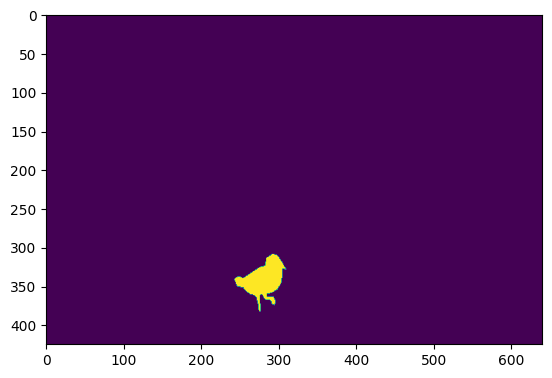

1

In [20]:
mask = dataset.coco.annToMask(dataset[400][1][0])
plt.imshow(mask)
plt.show()
mask.max()

In [2]:
sample = dataset[0]
img, target = sample
sample = dataset[0]
img = sample[0]
masks = sample[1]['masks']
bbox = sample[1]['bbox']
print("img shape & masks shape: ", np.array(img).shape, masks.shape)
print(type(masks.data))


img shape & masks shape:  (375, 500, 3) torch.Size([1, 375, 500])
<class 'torch.Tensor'>


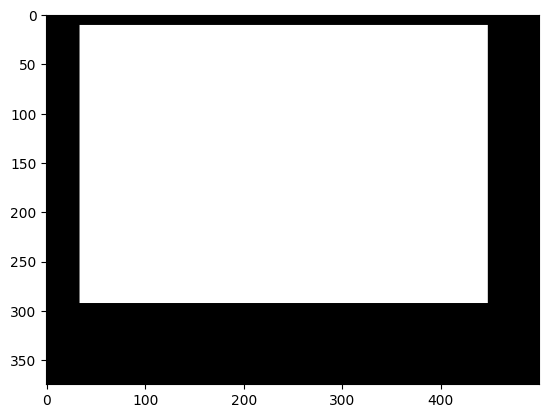

In [6]:
mask = masks.data[0]
mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
mask = mask.repeat((1,1,3))
# plt.imshow(np.array(img) * mask.numpy())
plt.imshow(mask*255)

In [20]:
import pycocotools
from pycocotools.coco import COCO
annFile = ANNOTATIONS_PATH 
coco=COCO(annFile)

loading annotations into memory...
Done (t=21.64s)
creating index...
index created!


In [23]:
coco.loadImgs(coco.getImgIds(catIds=[90])[:3]), coco.loadCats([90])

([{'license': 1,
   'file_name': '000000354306.jpg',
   'coco_url': 'http://images.cocodataset.org/train2017/000000354306.jpg',
   'height': 640,
   'width': 426,
   'date_captured': '2013-11-15 03:10:38',
   'flickr_url': 'http://farm8.staticflickr.com/7062/6893143985_fe0c0ed081_z.jpg',
   'id': 354306},
  {'license': 2,
   'file_name': '000000204804.jpg',
   'coco_url': 'http://images.cocodataset.org/train2017/000000204804.jpg',
   'height': 427,
   'width': 640,
   'date_captured': '2013-11-15 03:19:29',
   'flickr_url': 'http://farm8.staticflickr.com/7055/6945089703_393d186894_z.jpg',
   'id': 204804},
  {'license': 5,
   'file_name': '000000464902.jpg',
   'coco_url': 'http://images.cocodataset.org/train2017/000000464902.jpg',
   'height': 480,
   'width': 640,
   'date_captured': '2013-11-21 19:53:15',
   'flickr_url': 'http://farm2.staticflickr.com/1425/929688150_13f9f1efe3_z.jpg',
   'id': 464902}],
 [{'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}])

(mask[0] > 0).shape

In [104]:
imgIds = coco.getImgIds(catIds=[90])[:5]
annIds = coco.getAnnIds(imgIds=imgIds, catIds=[90], iscrowd=None)
anns = coco.loadAnns(annIds)
[(ann['image_id'], ann['category_id']) for ann in anns], imgIds
# [k for k in anns[0]], anns[0]['image_id']

([(354306, 90),
  (354306, 90),
  (204804, 90),
  (204804, 90),
  (464902, 90),
  (464902, 90),
  (464902, 90),
  (464902, 90),
  (464902, 90),
  (393223, 90),
  (176136, 90)],
 [354306, 204804, 464902, 393223, 176136])

In [245]:
for catId in coco.getCatIds():
    imgIds = coco.getImgIds(catIds=[catId])
    print(catId, len(imgIds))

1 64115
2 3252
3 12251
4 3502
5 2986
6 3952
7 3588
8 6127
9 3025
10 4139
11 1711
13 1734
14 705
15 5570
16 3237
17 4114
18 4385
19 2941
20 1529
21 1968
22 2143
23 960
24 1916
25 2546
27 5528
28 3968
31 6841
32 3810
33 2402
34 2184
35 3082
36 1654
37 4262
38 2261
39 2506
40 2629
41 3476
42 3486
43 3394
44 8501
46 2533
47 9189
48 3555
49 4326
50 3529
51 7111
52 2243
53 1586
54 2365
55 1699
56 1939
57 1683
58 1222
59 3166
60 1523
61 2925
62 12774
63 4423
64 4452
65 3682
67 11837
70 3353
72 4561
73 3524
74 1876
75 3076
76 2115
77 4803
78 1547
79 2877
80 217
81 4678
82 2360
84 5332
85 4659
86 3593
87 947
88 2140
89 189
90 1007


In [132]:
from os import path as osp
IMG_ROOT = "/root/datasets/COCO/train2017"
img = Image.open(osp.join(IMG_ROOT, coco.loadImgs(imgIds)[0]['file_name']))
img = np.array(img)

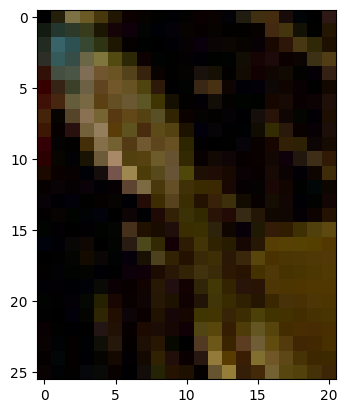

In [134]:
x, y, w, h = anns[0]['bbox']
x, y, w, h = int(x), int(y), int(w), int(h)

x, y, w, h 
plt.imshow(img[y:y+h, x:x+w])

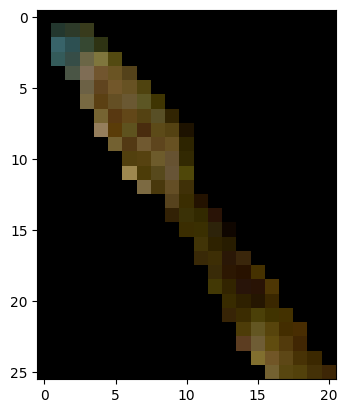

In [136]:
masked_img = coco.annToMask(anns[0])[:, :, None] * img
# Image.fromarray(masked_img).crop((x, y, x + w, y + h))
plt.imshow(masked_img[y:y+h, x:x+w])

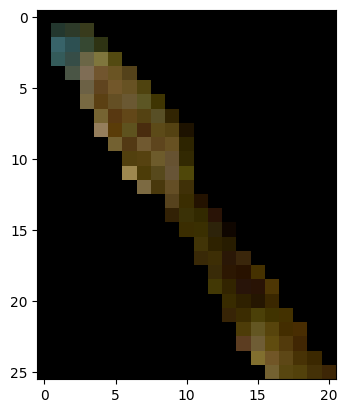

In [127]:
plt.imshow(masked_img[y:y+h, x:x+w,:])

In [220]:
import pycocotools
from pycocotools.coco import COCO
from copy import deepcopy
import random 
from functools import  lru_cache   
from PIL import Image 
import numpy as np 
import os.path as osp
# annFile = ANNOTATIONS_PATH 
# coco=COCO(annFile)



class COCOPrompter(object):
    def __init__(self, annFile, img_dir, shot=5, mask_rate=0.25):
        self.coco = COCO(annFile) 
        self.shot = shot
        self.mask_rate =  mask_rate
        self.img_dir = img_dir
        
        # init start index for each category
        catIds = self.coco.getCatIds()
        self.start_idx = dict()
        for i in catIds:
            self.start_idx[i] = 0

        self.catIds = catIds.copy()
    
    def get_cat_mask(self, catIds):
        """ 
            mask some categories with mask_rate

            return: new catIds with mask 

            e.g.
                cat_mask: [1, 1, 1, 0]
                catIds: [1, 30, 9, 4]
                category 4 is masked
        """     
        masked_num = int(self.mask_rate * len(catIds))
        if masked_num < 1:
            return [1 for _ in range(len(catIds))] 
        else: 
            mask_idx = random.sample(range(len(catIds)), masked_num)  
            mask = [1 for _ in range(len(catIds))]
            for i in mask_idx:
                mask[i] = 0
            return mask 

    def replace_masked_cat_with_other(self, catIds, mask):
        """ 
            mask: see self.get_cat_mask()
            e.g.
                cat_mask: [1, 1, 1, 0]
                catIds: [1, 30, 9, 4]
                category 4 is masked
                4 will be replaced with other category not in [1, 30, 9]
        """
        random.shuffle(self.catIds)
        # count mask:
        mask_num = len(mask) - sum(mask)
        
        if mask_num <= 0:
            # no need to replace
            return catIds 
        else: 
            ans = []
            for cat in self.catIds: 
                if cat not in catIds:
                    ans.append(cat)
                    if len(ans) == mask_num:
                        break
            
            j = 0
            for i in range(len(catIds)):
                if mask[i] == 0: 
                    catIds[i] = ans[j]
                    j += 1 
            return catIds 
            
    @lru_cache(maxsize=50)
    def imread(self, imgId):
        if isinstance(imgId, int):
            imgId = str(imgId) 
        imgId = imgId.zfill(12) + ".jpg"
        imgId = osp.join(self.img_dir, imgId)
        return np.array(Image.open(imgId))

    def get_instances_from_idx(self, idx: list,  catId: int):
        """ 
            idx: imgIds, N-shot images of category catId
            we need to random sample N-shot instances from N-shot images of category catId
            anns: [
                dict(
                    'segmentation',
                    'area',
                    'iscrowd',
                    'image_id',
                    'bbox',
                    'category_id',
                    'id'
                )
            ]
            idx: [int]
        """
        annIds = coco.getAnnIds(imgIds=idx, catIds=[catId], iscrowd=None)
        anns = coco.loadAnns(annIds) 
        samples_idx = random.sample(range(len(anns)), self.shot) 
        
        anns_new = []
        for i in samples_idx:
            anns_new.append(anns[i])
        idx_new = list(set([ann['image_id'] for ann in anns_new])) 
        
        # load imgs:
        imgs = dict() 
        for imgId in idx_new:
            imgs[imgId] = self.imread(imgId)
        
        # crop imgs:
        instances = []
        for ann in anns_new: 
            imgId = ann['image_id']
            # mask = self.coco.annToMask(ann)  # binary numpy mask
            img = imgs[imgId]    # numpy array

            # masked_instance = img * mask[:, :, None]    # broadcast
            bbox = ann['bbox']
            x, y, w, h = bbox
            x, y, w, h = int(x), int(y), int(w), int(h)
            masked_instance = img[y:y+h, x:x+w]
            instances.append(masked_instance)
            if len(instances) == self.shot:
                break 
        return instances 


    def get_n_shot_idx(self, catIds: list):
        """ 
            get N-shot image path for each category in catIds

            n_shot_idx: type is [[]]
            sample N-shot imgIds from coco.getImgIds(catIds=catIds)
        """
        n_shot_idx = []
        for cat in catIds:
            start_idx = self.start_idx[cat] 
            ImgIds = coco.getImgIds(catIds=[cat])

            len_ImgIds = len(ImgIds) 
            end_idx = start_idx + self.shot 

            idx = []
            if end_idx >= len_ImgIds:
                for i in range(self.shot):
                    idx.append(ImgIds[(start_idx + i) % len_ImgIds])
            else: 
                idx = ImgIds[start_idx: end_idx]
            
            
            n_shot_idx.append(idx)

            # update start index:
            self.start_idx[cat] += 1
            self.start_idx[cat] = self.start_idx[cat] % len_ImgIds
        
        return n_shot_idx 



    def prompt(self, catIds: list, masked=True):
        # get unique category ids:
        catIds = list(set(catIds))
        index = self.coco.getImgIds(catIds=catIds)

        if masked:
            # get mask_rate number of images prompt that not in catIds:
            catMask = self.get_cat_mask(catIds)
        else:
            catMask = [1 for _ in range(len(catIds))]
        # replace masked category with other categories:
        catIds = self.replace_masked_cat_with_other(catIds, catMask)

        n_shot_idx = self.get_n_shot_idx(catIds)
        
        instances = []
        for catId, idx in zip(catIds, n_shot_idx):
            n_shot_instances = self.get_instances_from_idx(idx, catId)
            instances.append(n_shot_instances)
        return dict(
            catIds=catIds,
            catNames=self.coco.loadCats(catIds),
            catMask=catMask,
            instances=instances
        )
        
# prompter = COCOPrompter(annFile, img_dir=IMG_ROOT)

loading annotations into memory...
Done (t=24.16s)
creating index...
index created!


In [170]:
coco.loadCats(coco.getCatIds())

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [236]:
visual_prompt = prompter.prompt(catIds=[13,88,86,19,20])
visual_prompt['catNames']

[{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'animal', 'id': 19, 'name': 'horse'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'indoor', 'id': 86, 'name': 'vase'},
 {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}]

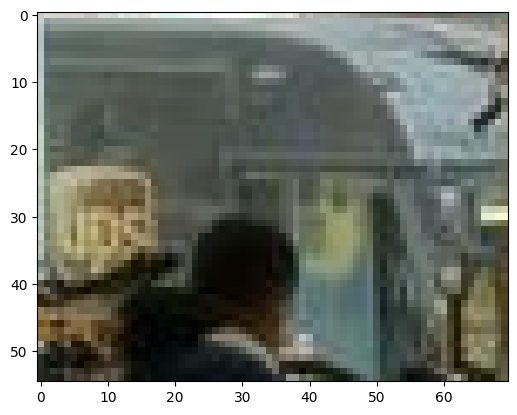

In [235]:
plt.imshow(visual_prompt['instances'][4][2])

In [214]:
visual_prompt

{'catIds': [88, 13],
 'catMask': [1, 1],
 'instances': [[array([[[124, 118, 106],
           [128, 124, 112],
           [125, 121, 109],
           ...,
           [194, 196, 195],
           [194, 196, 195],
           [191, 193, 192]],
   
          [[121, 115, 103],
           [124, 120, 108],
           [123, 119, 107],
           ...,
           [197, 199, 198],
           [199, 201, 200],
           [199, 201, 200]],
   
          [[126, 120, 106],
           [120, 116, 104],
           [122, 118, 106],
           ...,
           [197, 198, 200],
           [199, 200, 202],
           [201, 202, 204]],
   
          ...,
   
          [[ 90,  76,  65],
           [ 89,  80,  65],
           [ 86,  77,  62],
           ...,
           [185, 185, 183],
           [185, 185, 183],
           [184, 183, 179]],
   
          [[ 85,  73,  61],
           [ 82,  73,  58],
           [ 82,  73,  58],
           ...,
           [182, 183, 178],
           [182, 183, 178],
           [181

In [59]:
from PIL import Image 
import numpy as np 
@lru_cache
def imread():
    img = Image.open('/root/yunzhi/data/participant_property/images/0b4ef250500b65a556168f307fbf97f5.jpg')
    return img 


In [62]:
for _ in range(1000):
    imread()

In [48]:
random.randint(0, 5)

1